In [2]:
from src.sar_transformer.utils import load_concat_transformer
from src.sar_transformer.eval import evaluate_ad_agent
from src.sar_transformer.dataset import HistoryDataset, create_history_dataloader
from src.sar_transformer.eval import evaluate_ad_agent
from src.generation import *

import torch
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import einops
from tqdm import tqdm

import transformer_lens
from transformer_lens import utils
from transformer_lens.head_detector import *

import plotly.express as px

%matplotlib inline

pygame 2.3.0 (SDL 2.24.2, Python 3.9.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# model = load_concat_transformer("models\dark_room_test__1000__1685416926_checkpoints\checkpoint_epoch_200.pt").to("cuda")
#model = load_concat_transformer("models\dark_room_test__1000__1686153478_checkpoints\checkpoint_epoch_300.pt").to("cuda")
#model = load_concat_transformer("models/4l_darkroom.pt").to("cuda")
model = load_concat_transformer("models/4l_darkroom.pt").to("cuda")
env_config = model.environment_config

In [4]:
model.transformer_config

TransformerModelConfig(d_model=64, n_heads=4, d_mlp=512, d_head=16, n_layers=4, n_ctx=240, layer_norm=True, attn_only=False, state_embedding_type='linear', time_embedding_type='embedding', seed=1, device=device(type='cuda'))

In [5]:
def imshow(tensor, yaxis="", xaxis="", **kwargs):
  tensor = utils.to_numpy(tensor)
  plot_kwargs = {"color_continuous_scale":"RdBu", "color_continuous_midpoint":0.0, "labels":{"x":xaxis, "y":yaxis}}
  plot_kwargs.update(kwargs)
  return px.imshow(tensor, **plot_kwargs)

In [6]:
def states_to_onehot(states):
    one_hot_tensor=torch.nn.functional.one_hot(states, num_classes=env_config.n_states)
    return one_hot_tensor

In [7]:
def simulate_env(env,actions):
    states = np.zeros((1, 1, 12))
    obs=env.reset()
    states[0, 0] = obs
    for action in actions:
        obs, _, _, _, _ = env.step(action)
        states.append(obs) 
    return states

In [8]:
def array2tensors(state_buffer,action_buffer,reward_buffer):
    timesteps=list(range(len(state_buffer)))
    states = torch.as_tensor(state_buffer, dtype=torch.long, device=model.transformer_config.device).unsqueeze(0)
    actions = torch.as_tensor(action_buffer, dtype=torch.long, device=model.transformer_config.device).unsqueeze(0).unsqueeze(2)
    rewards = torch.as_tensor(reward_buffer, dtype=torch.double, device=model.transformer_config.device).unsqueeze(0).unsqueeze(2)
    timesteps = torch.as_tensor(timesteps, dtype=torch.long, device=model.transformer_config.device)
    states=states_to_onehot(states)
    return states,actions,rewards,timesteps

In [9]:
def buffer2tensors(state_buffer,action_buffer,reward_buffer):
    timesteps=list(range(len(state_buffer)))
    states = torch.as_tensor(state_buffer, dtype=torch.long, device=model.transformer_config.device)
    actions = torch.as_tensor(action_buffer, dtype=torch.long, device=model.transformer_config.device)[:,:-1]
    rewards = torch.as_tensor(reward_buffer, dtype=torch.double, device=model.transformer_config.device)[:,:-1]
    timesteps = torch.as_tensor(timesteps, dtype=torch.long, device=model.transformer_config.device)
    return states,actions,rewards,timesteps

In [10]:
env=env_config.env 

### Setup Head Detection


### Interpretability Experiments

How can we figure out what internal circuits best explain model performance

 - train supervised probes and check what features they look for
 - Use head_detector to find heads that look for previous observations

EVAL  - Random walk score: 2.3300, Optimal score: 7.8450, AD high score: 6.7000, AD final score: 6.7000: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


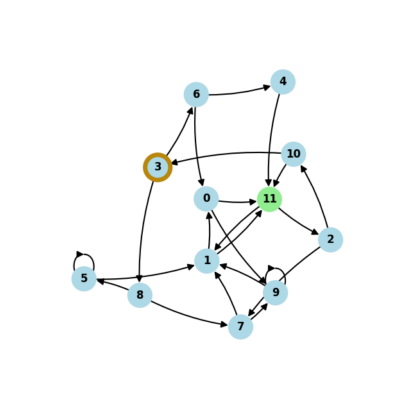

In [11]:
state_buffer, action_buffer, reward_buffer, embeddings, cache_eval = evaluate_ad_agent(model, env_config, 10, return_cache=True)
plt.figure(figsize = (5, 5))
plt.imshow(env_config.env.render(), interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
reward_steps=np.where(reward_buffer == 1) 
reward_steps

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([  7,  29,  34,  51,  54,  57,  60,  63,  66,  69,  74,  77,  80,
         83,  86,  89,  92,  95,  98, 101, 104, 107, 110, 113, 116, 123,
        126, 129, 132, 135, 138, 141, 144, 147, 150, 153, 156, 159, 162,
        165, 170, 173, 176, 179, 182, 185, 188, 193, 196, 199, 202, 205,
        208, 211, 214, 216, 219, 222, 225, 228, 231, 234, 237]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [ ]:
modified_reward_buffer=reward_buffer.copy()
modified_reward_buffer[0][reward_steps[1][0]]=0

states,actions,rewards,timesteps = buffer2tensors(state_buffer,action_buffer,modified_reward_buffer)
embeddings = model.to_tokens(
                states=states,
                actions=actions,
                rewards=rewards,
                timesteps=timesteps,)

In [ ]:
_, cache2 = model.transformer.run_with_cache(embeddings)


In [ ]:
cache["hook_embed"].squeeze(0)[5]

tensor([ 0.1787, -0.4990,  0.4058,  0.5771, -0.4311,  0.2398,  0.1542,  0.7358,
        -0.4928, -0.3539,  0.0248,  0.0337, -0.5164, -0.4104, -0.0582, -0.2270,
         0.8175, -0.6059, -0.0013, -0.3679, -0.3024,  0.4921,  0.3505,  0.3552,
        -0.0936, -0.9239, -0.9529, -0.3844, -0.3081, -0.5174, -0.2567,  0.0985,
         0.0168,  0.5252,  0.2123, -0.4217,  0.7182,  0.4181,  0.2193, -0.2475,
         0.8082, -0.3045,  0.1310,  0.0174, -0.4081, -0.5626,  0.0881, -0.0351,
        -0.2092,  0.3526,  0.9241,  0.1609,  0.1586, -0.2638, -0.0152,  0.1885,
         0.0765,  0.3374,  0.3901,  0.6516,  0.1161, -0.3637, -0.9715, -0.4599],
       device='cuda:0')

In [ ]:
cache2["hook_embed"].squeeze(0)[5]

tensor([-0.0253, -0.5284,  0.2797, -0.2988,  0.0931,  0.4561,  0.1271,  0.3191,
        -0.7701, -0.2059, -0.1738,  0.1006, -0.3161, -0.4542, -0.1639, -0.4002,
         0.3845, -0.4063,  0.3681, -0.3236, -0.1158,  0.5973, -0.0336,  0.1362,
        -0.9230, -0.3800, -1.2410,  0.3234, -0.2965, -0.6034, -0.8325,  0.0209,
         0.2622,  0.0211, -0.1489, -0.8661,  0.3878,  0.2304,  0.3338, -0.0765,
         0.5980, -0.0144, -0.2443,  0.4818,  0.3503, -0.2617,  0.4977,  0.2613,
         0.0349,  0.6344,  1.0198,  0.2896,  0.1187, -0.1747, -0.3224, -0.1766,
         0.4176, -0.2933,  0.8315,  0.1417,  0.4281,  0.2645, -0.4450, -0.8696],
       device='cuda:0')

In [ ]:
imshow(cache["hook_embed"].squeeze(0))

In [ ]:
imshow(cache2["hook_embed"].squeeze(0))

In [ ]:
imshow(cache2["hook_embed"].squeeze(0)-cache["hook_embed"].squeeze(0))

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_re

In [ ]:

imshow(cache["blocks.0.ln1.hook_normalized"].squeeze(0).T).show()

In [ ]:
imshow(cache["blocks.0.attn.hook_q"].squeeze(0)[:,0].T).show()
imshow(cache["blocks.0.attn.hook_k"].squeeze(0)[:,0].T).show()
imshow(cache["blocks.0.attn.hook_k"].squeeze(0)[1:10,0,:].T).show()

In [ ]:
cache["blocks.0.attn.hook_attn_scores"].shape

torch.Size([1, 4, 240, 240])

In [ ]:
reward_steps

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 14,  23,  69,  71,  78,  84,  90,  98, 104, 110, 117, 123, 129,
        136, 142, 143, 149, 155, 161, 173, 179, 186, 191, 197, 203, 209,
        215, 222, 228, 234]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]))

In [ ]:
new_tensor = torch.where(cache["blocks.0.attn.hook_attn_scores"].squeeze(0)[0].cpu() < -100, torch.tensor(-2), cache["blocks.0.attn.hook_attn_scores"].squeeze(0)[0].cpu() )
imshow(new_tensor)#.squeeze(0)


In [ ]:
fig=imshow(cache['blocks.0.ln1.hook_normalized'].squeeze(0)) 
fig.update_layout(
    title=f'embed Heatmap'
)
fig.show()
for i in range(model.transformer_config.n_layers):
    fig=imshow(cache[f'blocks.{i}.hook_resid_post'].squeeze(0))
    fig.update_layout(
    title=f'Layer {i} Heatmap'
)
    fig.show()

In [ ]:
previous_stream= cache['blocks.0.ln1.hook_normalized'].squeeze(0)
fig=imshow(cache['blocks.0.ln1.hook_normalized'].squeeze(0)) 
fig.show()
for i in range(model.transformer_config.n_layers):
    fig=imshow(cache[f'blocks.{i}.hook_resid_post'].squeeze(0)-previous_stream)
    fig.update_layout(
    title=f'layer {i} contribution'#maybe should calculate differentely
)
    fig.show()
    previous_stream=cache[f'blocks.{i}.hook_resid_post'].squeeze(0)

In [ ]:
cache["blocks.5.hook_resid_post"].shape

KeyError: 'blocks.5.hook_resid_post'

In [ ]:
env_config.env.reward_rules

[[11, -1, 1, 1.0, 1.0, -1]]

In [ ]:
def display_head(cache, labels, layer, head, n_episodes=3):
    average_patterns = cache[f"blocks.{layer}.attn.hook_pattern"]
    matrix = average_patterns[0, head, :24*n_episodes, :24*n_episodes].cpu()
    fig = px.imshow(
        matrix,
        labels=dict(x="AttendedPos", y="CurrentPos", color="Value"),
    )
    layout = dict(
        width=800,
        height=800,
        xaxis=dict(
            tickmode="array",
            tickvals=np.arange(len(labels)),
            ticktext=labels,
        ),
        yaxis=dict(
            tickmode="array",
            tickvals=np.arange(len(labels)),
            ticktext=labels,
        )
    )
    fig.update_layout(layout)

    fig.show()

    

In [ ]:
def display_head(cache, labels, layer, head, n_episodes=3):
    average_patterns = cache[f"blocks.{layer}.attn.hook_pattern"]
    matrix = average_patterns[0, head, :24*n_episodes, :24*n_episodes].cpu()
    fig = px.imshow(
        matrix,
        labels=dict(x="AttendedPos", y="CurrentPos", color="Value"),
    )
    layout = dict(
        width=800,
        height=800,
        xaxis=dict(
            tickmode="array",
            tickvals=np.arange(len(labels)),
            ticktext=labels,
        ),
        yaxis=dict(
            tickmode="array",
            tickvals=np.arange(len(labels)),
            ticktext=labels,
        )
    )
    fig.update_layout(layout)

    fig.show()


In [ ]:
display_head(cache, labels, 2, 0, 3)

NameError: name 'labels' is not defined